In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Using `regionmask` and `sectionate` to evaluate the convergence of vertically-integrated mass fluxes

In [10]:
# Import packages
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt

import sectionate as sec
import regionate as reg

# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size':12})

### Load data

In [11]:
from load_example_model_grid import load_MOM6_zint_mass_budget
grid = load_MOM6_zint_mass_budget()
ds = grid._ds

# Thermdynamic constants used in Boussinesq mass budget
rho0 = 1035. # kg/m^3

File 'MOM6_global_example_vertically_integrated_mass_budget_v0_0_6.nc' already exists at ../data/MOM6_global_example_vertically_integrated_mass_budget_v0_0_6.nc. Skipping download.


#### Plot vertically-integrated thickness budget

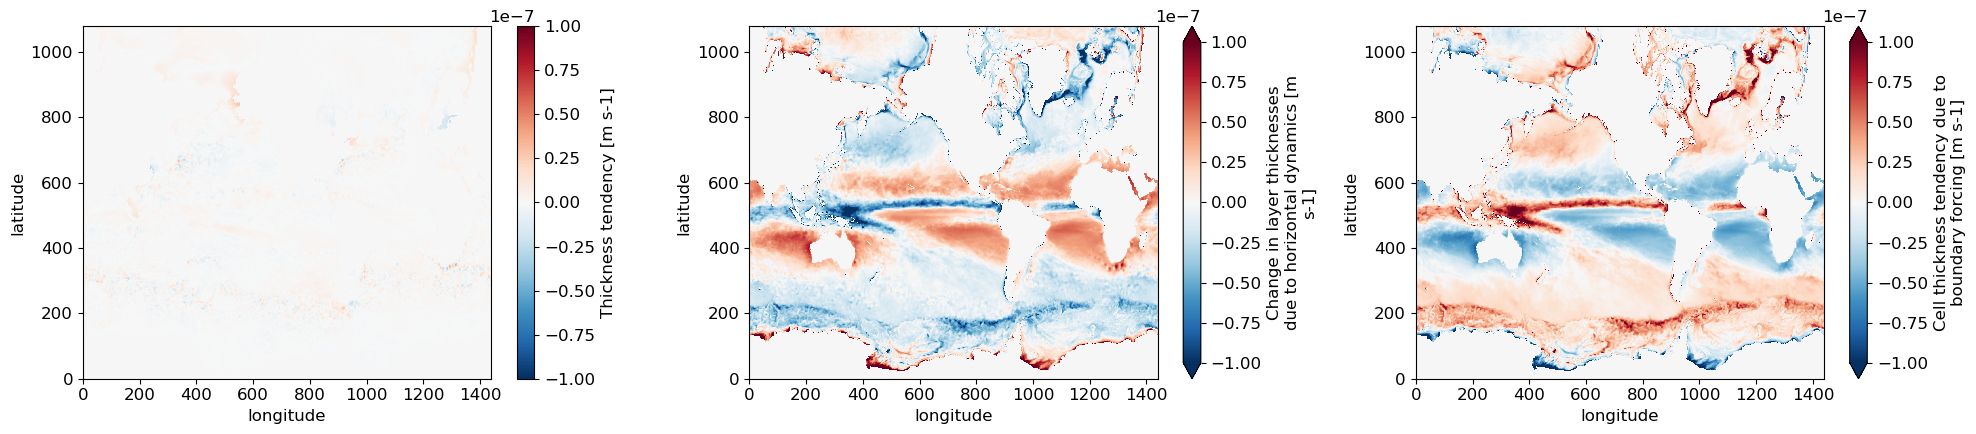

In [12]:
fig, axes = plt.subplots(1,3, figsize=(20, 4.5))
ds['dhdt'].plot(ax=axes[0], vmin=-1e-7, vmax=1e-7, cmap="RdBu_r")
ds['dynamics_h_tendency'].plot(ax=axes[1], vmin=-1e-7, vmax=1e-7, cmap="RdBu_r")
ds['boundary_forcing_h_tendency'].plot(ax=axes[2], vmin=-1e-7, vmax=1e-7, cmap="RdBu_r")
for ax in axes:
    ax.set_title("")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
plt.tight_layout()

#### Define an arbitrary close sub-region of the domain defined by an irregular polygon

We zoom in on the Greater Baltic Sea region analyzed in [Drake et al. 2025](https://doi.org/10.1029/2024MS004383).

In [13]:
name = "Baltic"
lons = np.array([13, 10, 9.0, 10., 12, 20.,  29., 24.5, 23.5, 22.5, 17.5])
lats = np.array([58, 57.5, 56, 54, 53.5, 53.5, 54.5,  59.,  61.,  63., 64.5])
region = reg.GriddedRegion(name, lons, lats, grid)

AttributeError: 'GriddedRegion' object has no attribute 'lons'

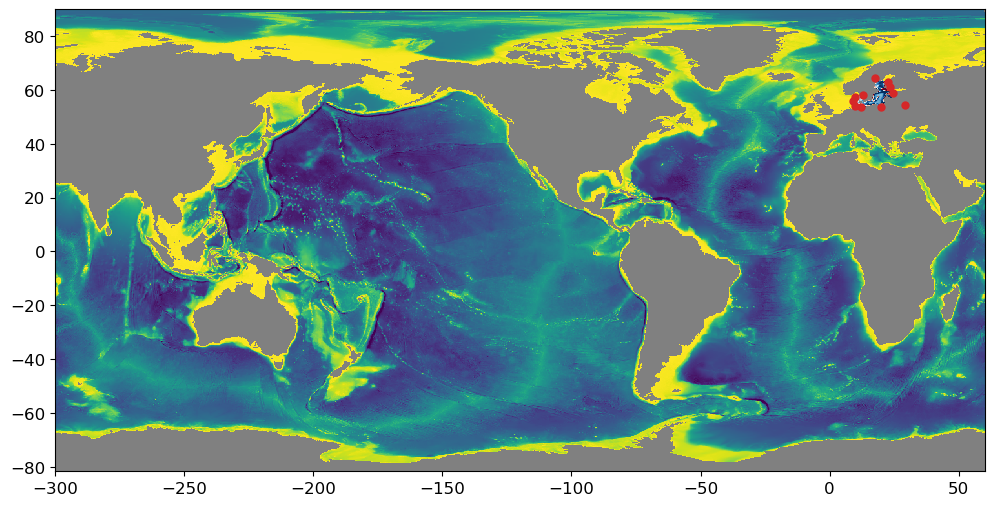

In [14]:
dhdt_dynamics = ds['dynamics_h_tendency']*ds['areacello']*1.e-6

plt.figure(figsize=(12, 6))
plt.subplot(facecolor="grey")
pc = plt.pcolormesh(
    ds['geolon'], ds['geolat'],
    dhdt_dynamics.where(region.mask).where(dhdt_dynamics!=0.).squeeze(),
    alpha=1.0, cmap="RdBu_r", vmin=-1e-5, vmax=1e-5
)
pc_dep = plt.pcolormesh(ds['geolon'], ds['geolat'], ds.deptho.where(~region.mask).where(ds.deptho!=0), cmap="viridis_r")
plt.plot(lons, lats, "C3o", markersize=5)
plt.plot(reg.loop(region.lons), reg.loop(region.lats), "k-", linewidth=0.5)
plt.plot(region.lons_uv, region.lats_uv, "k.", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column volume tendency [Sv]")
plt.xlim(5, 35)
plt.ylim(50, 70)
plt.tight_layout()

#### Verifying the 2D Divergence theorem for area integrals over complicated sub-domains

The specific thickness equation in Boussinesq configurations of MOM6 is given by
\begin{equation}
\partial_{t} h + \nabla_{r} \cdot (\mathbf{u} h) + \delta_{r}(z_{r} \dot{r}) = \dot{h}.
\end{equation}

Integrating in $z$ and over a region $(x,y)\in \mathcal{R}$ (like the sub-domain defined above), the volume budget is
\begin{equation}
\partial_{t} \mathcal{V} = \iint_{\mathcal{R}} - \nabla \cdot \mathbf{U} \, \text{d}A + \dot{\mathcal{V}}. \quad\quad\text{where }\mathbf{U} \equiv \int \mathbf{u} h \,\text{d}z
\end{equation}

Applying the divergence theorem, we can rewrite the thickness advection term as
\begin{equation}
\iint_{\mathcal{R}} -\nabla \cdot \mathbf{U} \, \text{d}A = \int_{\partial \mathcal{R}}  \mathbf{U} \cdot \mathbf{n}_{in} \,\text{d}l \equiv \Psi, 
\end{equation}
with $\Psi$ the horizontally convergent volume transport, integrating along the region's boundary $\partial \mathcal{R}$. Evaluating the LHS area integral is straightforward–just apply a Boolean mask to the diagnosed dynamical thickness tendency term. For the RHS boundary integral term, however, we have to accumulate the normal velocities (e.g. with positive consistently defined inwards) along the region's boundary. This is more more complicated process, but is achieved thanks to `regionate`'s companion package [`sectionate`](https://github.com/hdrake/sectionate).

We now compute both sides of the equation and check whether they are self-consistent (within machine precision).

In [15]:
Ψ0_tend = dhdt_dynamics.where(region.mask).sum(['xh', 'yh']).values # LHS

Tconv = sec.convergent_transport(grid, region.i_c, region.j_c, layer="z_l", interface="z_i")
Ψ = Tconv['conv_mass_transport'].cumsum("sect").sel(z_l=ds.z_l[::-1]).cumsum('z_l').sel(z_l=ds.z_l[::-1]).compute() # kg/s
Ψ0 = Ψ.isel(sect=-1, z_l=-1).values/rho0*1.e-6 # RHS

print(f"Check whether the discrete Divergence Theorem holds: {np.isclose(Ψ0, Ψ0_tend, rtol=1.e-6, atol=0)}") # single precision floating point

Check whether the discrete Divergence Theorem holds: [[ True]]


We can close the budget to single-precision floating point (float32) precision, which is the best we can hope for given the precision of our diagnostics.

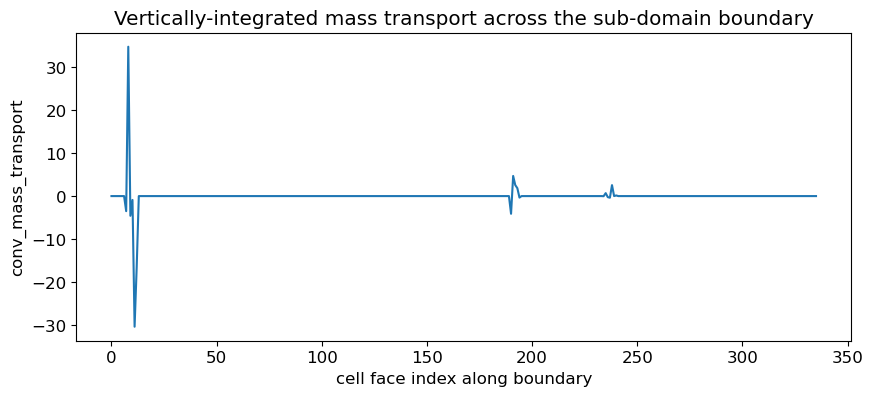

In [16]:
plt.figure(figsize=(10, 4))
(Tconv['conv_mass_transport']/rho0*1e-3).plot()
plt.title("Vertically-integrated mass transport across the sub-domain boundary")
plt.xlabel("cell face index along boundary");